### This notebook is to explore the remaining exploration and cleaning of the data meant to be used for trainng.


In [2]:
from typing import Tuple
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
def original_load_and_preprocessing(train_path: str, separate_features_and_labels:bool=True):
    """
    Loads Titanic data, applies preprocessing, and returns features and labels likein the provided notebook.
    """
    # Load data
    df = pd.read_csv(train_path)

    # Drop unnecessary columns
    drop_cols = ['Name', 'Ticket', 'Cabin']
    df = df.drop(columns=drop_cols)

    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna('S')

    # One-hot encoding
    embark_dummies = pd.get_dummies(df['Embarked'])
    sex_dummies = pd.get_dummies(df['Sex'])
    pclass_dummies = pd.get_dummies(df['Pclass'], prefix="Class")
    df = df.drop(['Embarked', 'Sex', 'Pclass'], axis=1)
    df = df.join([embark_dummies, sex_dummies, pclass_dummies])
    
    # Set PassengerId as index (optional, but clarifies it's not a feature)
    df = df.set_index('PassengerId')
    if separate_features_and_labels==False:
        return df
    else:
        # Separate features and labels
        X = df.drop('Survived', axis=1)
        y = df['Survived']
        return X, y
original_df_for_trainig = original_load_and_preprocessing(train_path='../data/train.csv',separate_features_and_labels=False)

display(original_df_for_trainig)

,Survived,Age,SibSp,Parch,Fare,C,Q,S,female,male,Class_1,Class_2,Class_3
PassengerId,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,True,False,True,False,False,True
2,1,38.0,1,0,71.2833,True,False,False,True,False,True,False,False
3,1,26.0,0,0,7.9250,False,False,True,True,False,False,False,True
4,1,35.0,1,0,53.1000,False,False,True,True,False,True,False,False
5,0,35.0,0,0,8.0500,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,27.0,0,0,13.0000,False,False,True,False,True,False,True,False
888,1,19.0,0,0,30.0000,False,False,True,True,False,True,False,False
889,0,28.0,1,2,23.4500,False,False,True,True,False,False,False,True


In [ ]:
len([23, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1 ])

12

In [3]:
max(original_df_for_trainig['Fare'])

512.3292

<Axes: xlabel='SibSp', ylabel='Survived'>

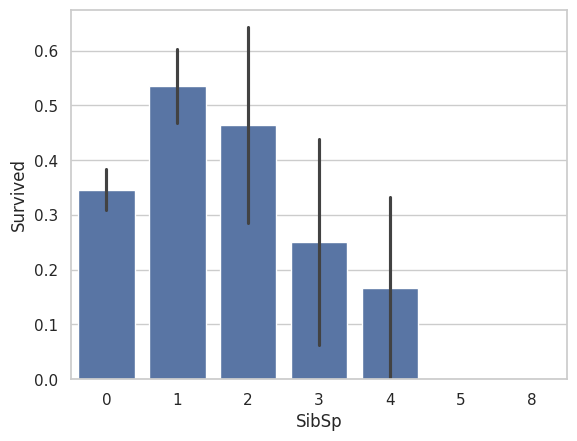

In [ ]:
#take a look to SibSp: # of siblings / spouses aboard the Titanic	
sns.barplot(x="SibSp", y="Survived", data=original_df_for_trainig)

<Axes: xlabel='Parch', ylabel='Survived'>

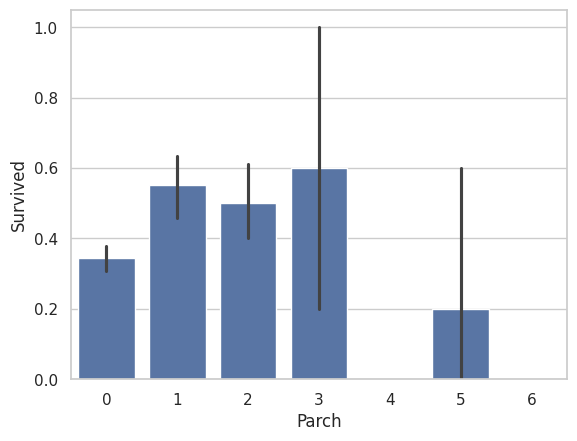

In [ ]:
# And to Parch: # of parents / children aboard the Titanic	
sns.barplot(x="Parch", y="Survived", data=original_df_for_trainig)

In [ ]:
# delete spare dummies to avoid multicolinearity
dummy_groups = {
    'Sex': ['female', 'male'],
    'Embarked': ['C', 'Q', 'S'],
    'Pclass': ['Class_1', 'Class_2', 'Class_3']
}
columns_to_drop = [cols[0] for cols in dummy_groups.values()]

from sklearn.base import BaseEstimator, TransformerMixin

class DropSpareDummies(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        # No fitting necessary, but method required by scikit-learn
        return self
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
dropper = DropSpareDummies(columns_to_drop=columns_to_drop)
df_dropped = dropper.transform(original_df_for_trainig)
display(df_dropped)

,Survived,Age,SibSp,Parch,Fare,Q,S,male,Class_2,Class_3
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,True,True,False,True
2,1,38.0,1,0,71.2833,False,False,False,False,False
3,1,26.0,0,0,7.9250,False,True,False,False,True
4,1,35.0,1,0,53.1000,False,True,False,False,False
5,0,35.0,0,0,8.0500,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
887,0,27.0,0,0,13.0000,False,True,True,True,False
888,1,19.0,0,0,30.0000,False,True,False,False,False
889,0,28.0,1,2,23.4500,False,True,False,False,True


In [ ]:

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class TitanicInputTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms Titanic input DataFrame into model-ready features.
    Always receives and returns a DataFrame.
    """
    def __init__(self, columns_to_drop=None):
        self.pclass_map = {'1st Class': 1, '2nd Class': 2, '3rd Class': 3, 1: 1, 2: 2, 3: 3}
        self.sex_map = {'male': 'male', 'female': 'female', 'Male': 'male', 'Female': 'female'}
        self.embarked_map = {'C': 'C', 'Q': 'Q', 'S': 'S'}
        self.dummy_columns = ['C', 'Q', 'S', 'female', 'male', 'Class_1', 'Class_2', 'Class_3']
        self.columns_to_drop = columns_to_drop or ['C', 'female', 'Class_1']
    def fit(self, X, y=None):
        return self

    def transform(self, df):
        # Ensure input is a DataFrame
        df = df.copy()
        df['Pclass'] = df['Pclass'].map(self.pclass_map)
        df['Sex'] = df['Sex'].map(self.sex_map)
        df['Embarked'] = df['Embarked'].map(self.embarked_map)
        df['Age'] = df['Age'].fillna(28)
        df['Fare'] = df['Fare'].fillna(32)
        df['Embarked'] = df['Embarked'].fillna('S')

        # One-hot encode
        embark_dummies = pd.get_dummies(df['Embarked'])
        sex_dummies = pd.get_dummies(df['Sex'])
        pclass_dummies = pd.get_dummies(df['Pclass'], prefix="Class")

        # Concatenate all features
        out = pd.concat([
            df[['Age', 'SibSp', 'Parch', 'Fare']].reset_index(drop=True),
            embark_dummies.reindex(columns=['C', 'Q', 'S'], fill_value=0).reset_index(drop=True),
            sex_dummies.reindex(columns=['female', 'male'], fill_value=0).reset_index(drop=True),
            pclass_dummies.reindex(columns=['Class_1', 'Class_2', 'Class_3'], fill_value=0).reset_index(drop=True)
        ], axis=1)

        # Drop spare dummies if needed
        if self.columns_to_drop:
            out = out.drop(columns=self.columns_to_drop, errors='ignore')

        return out
    
input_objs = [
    {
        'Pclass': '1st Class',
        'Sex': 'Female',
        'Age': 17,
        'SibSp': 0,
        'Parch': 1,
        'Fare': 53.1,
        'Embarked': 'S'
    },
    {
        'Pclass': '3rd Class',
        'Sex': 'Male',
        'Age': 23,
        'SibSp': 0,
        'Parch': 0,
        'Fare': 0,
        'Embarked': 'S'
    }
]

df = pd.DataFrame(input_objs)
transformer = TitanicInputTransformer()
feature_matrix = transformer.transform(df)
display(feature_matrix)

,Age,SibSp,Parch,Fare,Q,S,male,Class_2,Class_3
0,17,0,1,53.1,0,True,False,0,False
1,23,0,0,0.0,0,True,True,0,True
